Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


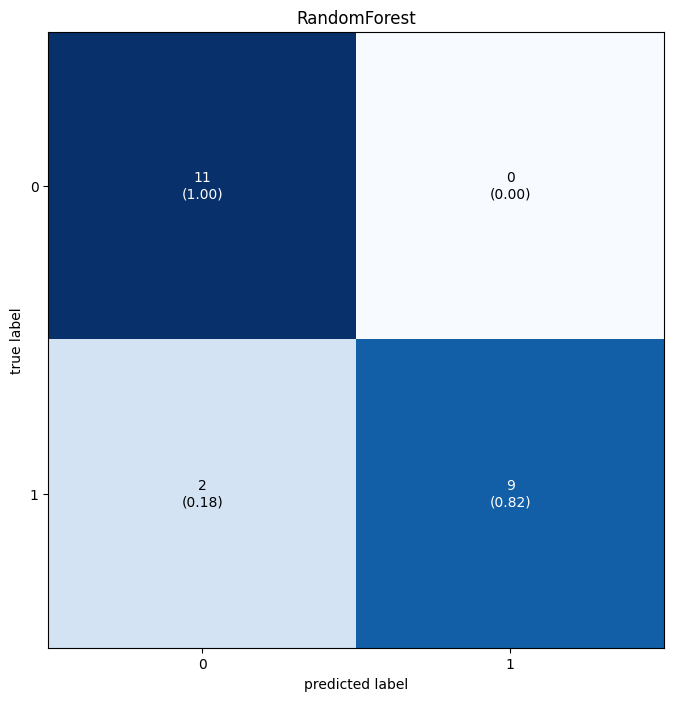

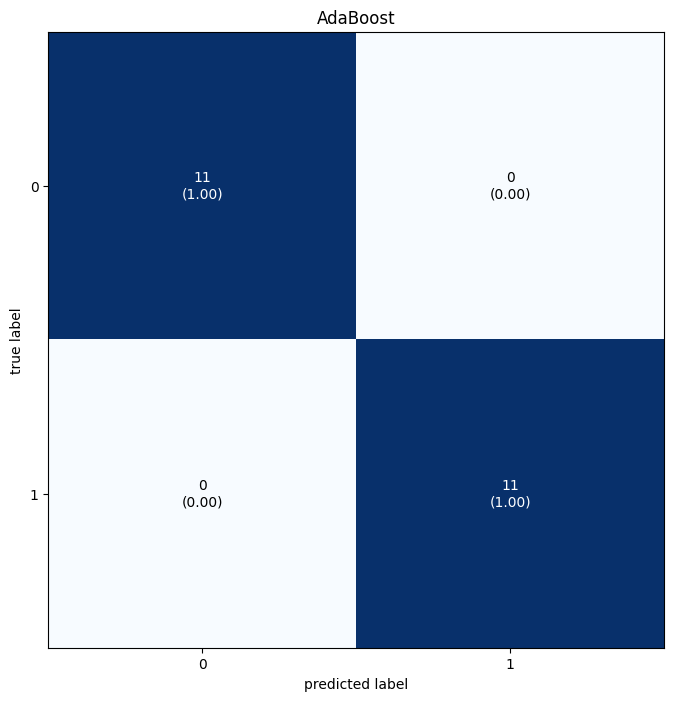

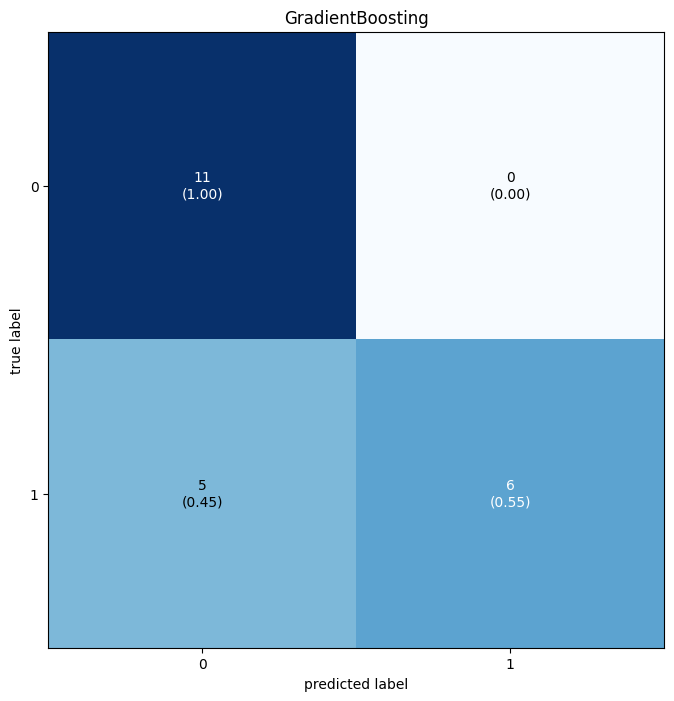

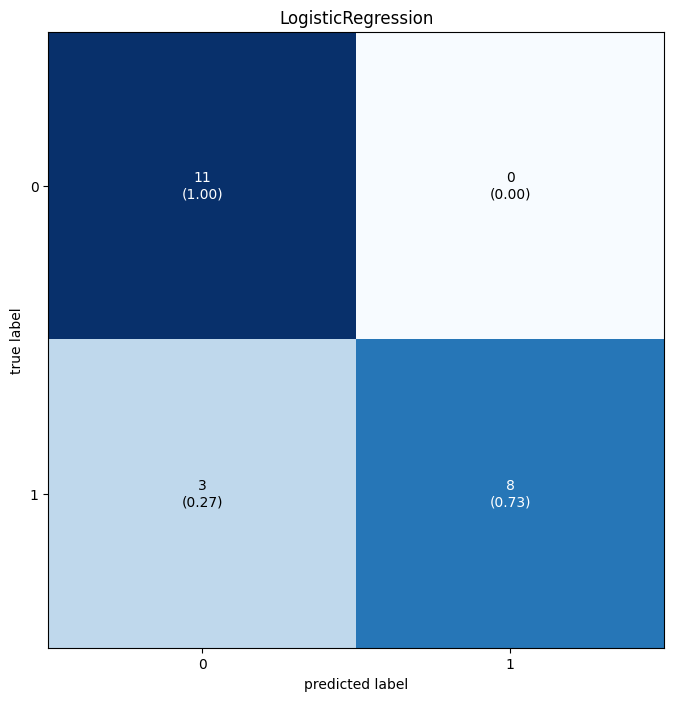

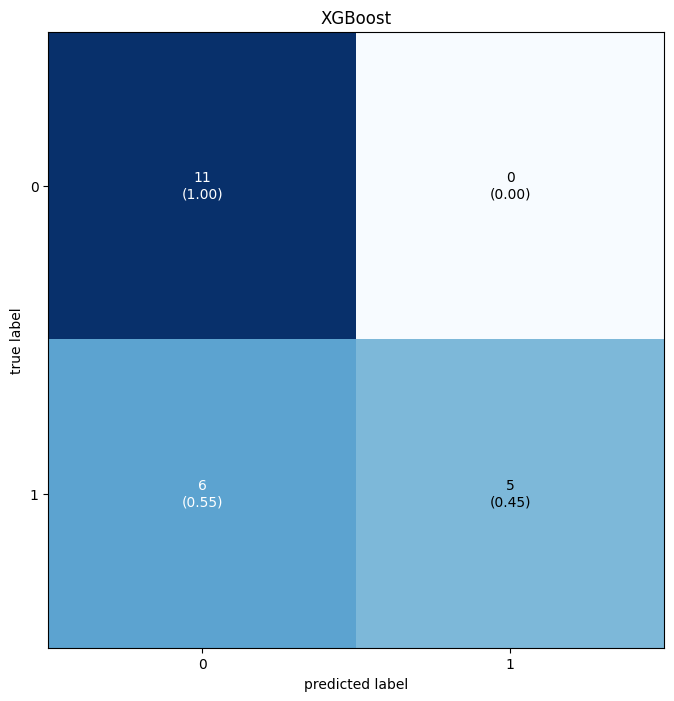

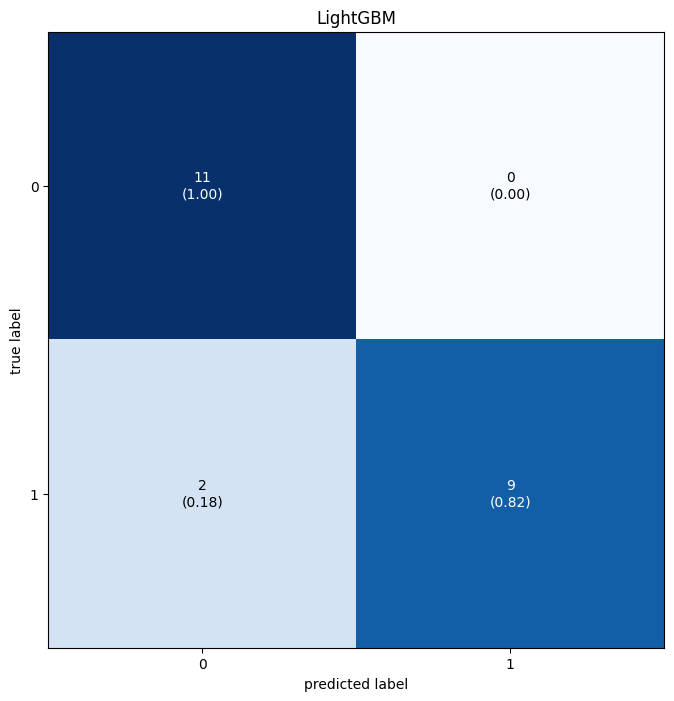

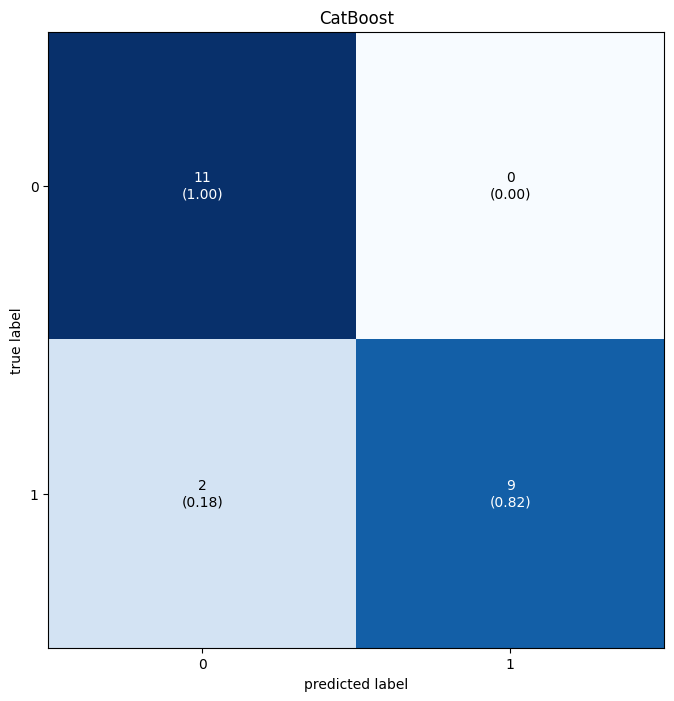

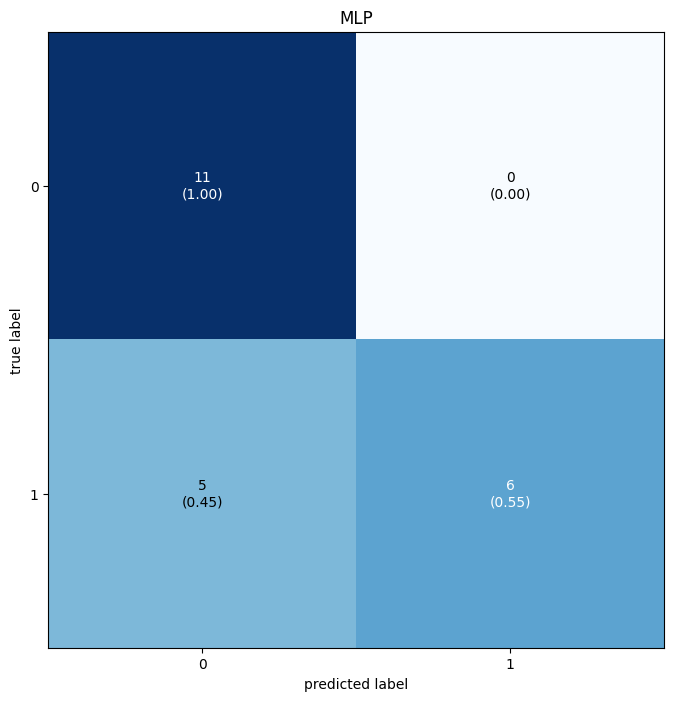

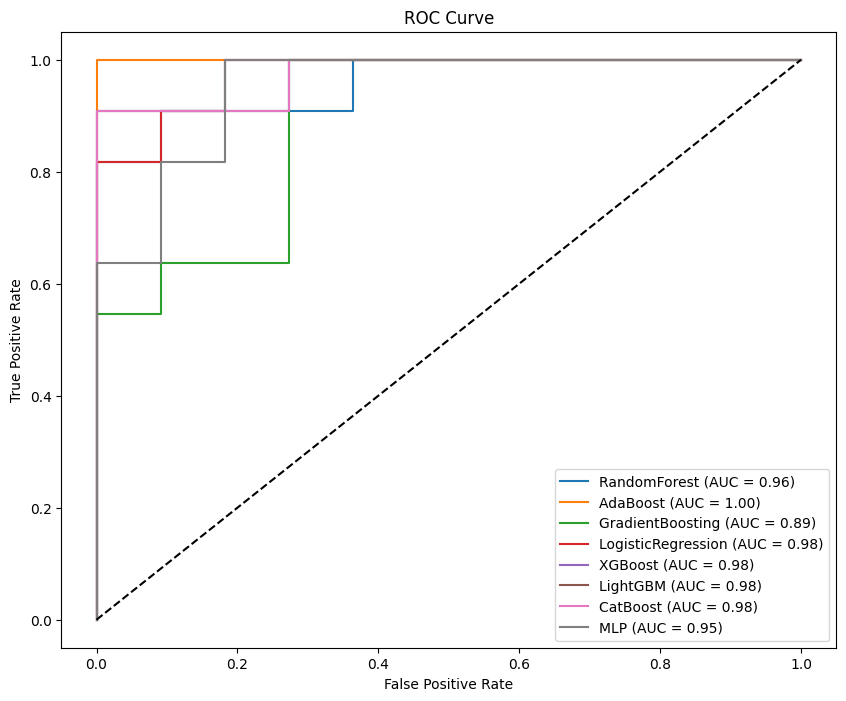

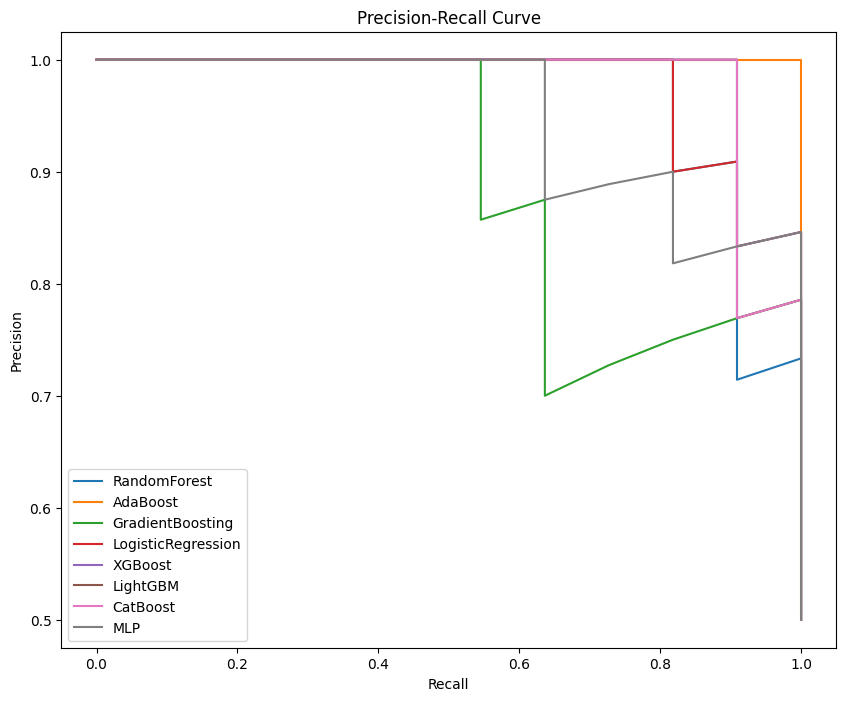

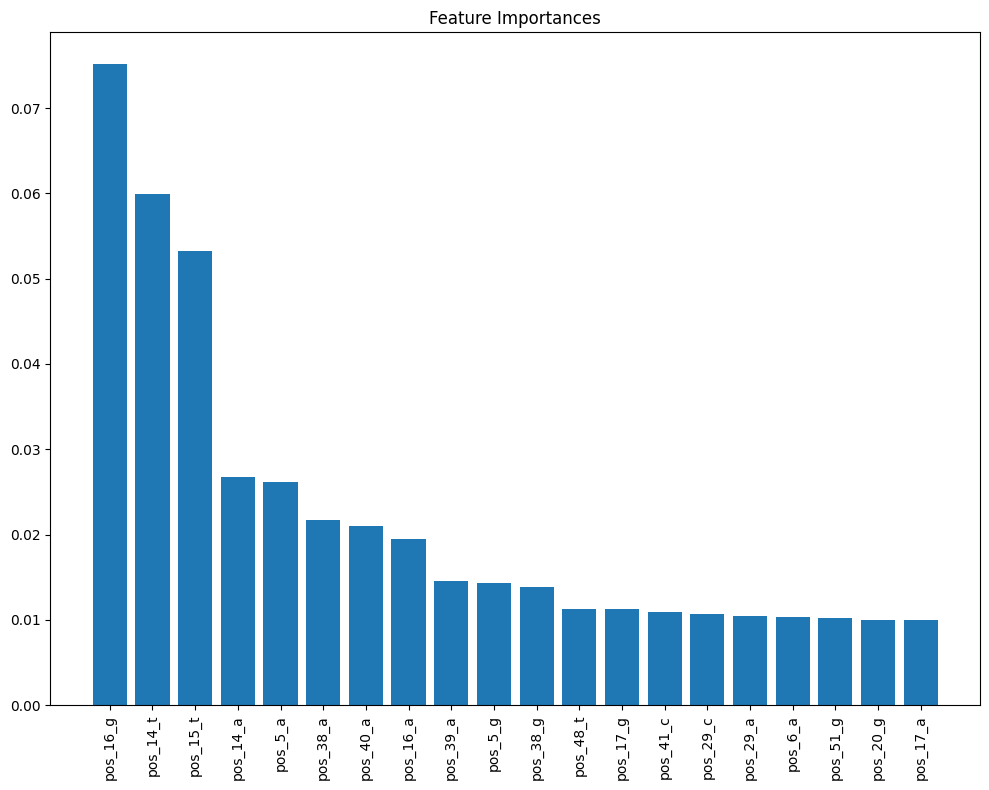

In [7]:
# Imports
from google.colab import drive
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score, precision_score, recall_score, roc_curve, auc, precision_recall_curve
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.neural_network import MLPClassifier
import time
import logging
from mlxtend.plotting import plot_confusion_matrix

# Mount Google Drive
drive.mount('/content/drive')

# Set up logging
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

# File path
file_path = '/content/drive/My Drive/dna_classify/promoters.data'

# Load and preprocess data
def load_and_preprocess_data(file_path):
    try:
        df = pd.read_csv(file_path, names=['class', 'id', 'sequence'])
        df['sequence'] = df['sequence'].apply(lambda x: x.replace("\t", ""))
        return df
    except Exception as e:
        logger.error(f"Error loading data: {e}")
        return None

# Create dictionary of sequences
def create_sequence_dict(df):
    nucleotit_dict = {}
    sequences = df["sequence"].tolist()
    for i, sequence in enumerate(sequences):
        nucleotit = list(sequence)
        nucleotit.append(df.loc[i, "class"])
        nucleotit_dict[i] = nucleotit
    return pd.DataFrame(nucleotit_dict).transpose()

# Prepare features and target
def prepare_data(df):
    le = LabelEncoder()
    y = le.fit_transform(df['class'])
    X = df.drop('class', axis=1)

    # Create dummy variables for each nucleotide at each position
    X_encoded = pd.get_dummies(X, prefix=[f'pos_{i}' for i in range(len(X.columns))], prefix_sep='_')

    return X_encoded, y, le

# Define models
def get_models():
    return {
        'RandomForest': RandomForestClassifier(random_state=42),
        'AdaBoost': AdaBoostClassifier(random_state=42),
        'GradientBoosting': GradientBoostingClassifier(random_state=42),
        'LogisticRegression': LogisticRegression(random_state=42),
        'XGBoost': XGBClassifier(random_state=42),
        'LightGBM': LGBMClassifier(random_state=42, verbose=-1),
        'CatBoost': CatBoostClassifier(random_state=42, verbose=0),
        'MLP': MLPClassifier(random_state=42)
    }

# Train and evaluate models
def train_and_evaluate(models, X_train, X_test, y_train, y_test):
    results = []
    for name, model in models.items():
        start_time = time.time()
        model.fit(X_train, y_train)
        train_time = time.time() - start_time

        start_time = time.time()
        y_pred = model.predict(X_test)
        test_time = time.time() - start_time

        cv_scores = cross_val_score(model, X_train, y_train, cv=5)

        results.append({
            'Model Name': name,
            'Train Time': train_time,
            'Test Time': test_time,
            'Train Accuracy': model.score(X_train, y_train),
            'Test Accuracy': accuracy_score(y_test, y_pred),
            'CV Accuracy': cv_scores.mean(),
            'F1': f1_score(y_test, y_pred, average='weighted'),
            'Precision': precision_score(y_test, y_pred, average='weighted'),
            'Recall': recall_score(y_test, y_pred, average='weighted')
        })

        logger.info(f"\nResults for {name}:")
        logger.info(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
        logger.info("Classification Report:")
        logger.info(classification_report(y_test, y_pred))

        plot_confusion_matrix(conf_mat=confusion_matrix(y_test, y_pred), figsize=(8, 8), show_absolute=True, show_normed=True)
        plt.title(name)
        plt.show()

    return pd.DataFrame(results)

# Plot ROC curve
def plot_roc_curve(models, X_test, y_test):
    plt.figure(figsize=(10, 8))
    for name, model in models.items():
        y_pred_proba = model.predict_proba(X_test)[:, 1]
        fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
        auc_score = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f'{name} (AUC = {auc_score:.2f})')

    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend()
    plt.show()

# Plot precision-recall curve
def plot_precision_recall_curve(models, X_test, y_test):
    plt.figure(figsize=(10, 8))
    for name, model in models.items():
        y_pred_proba = model.predict_proba(X_test)[:, 1]
        precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
        plt.plot(recall, precision, label=name)

    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.legend()
    plt.show()

# Feature importance
def plot_feature_importance(model, feature_names):
    if hasattr(model, 'feature_importances_'):
        importances = model.feature_importances_
        indices = np.argsort(importances)[::-1]
        plt.figure(figsize=(10, 8))
        plt.title("Feature Importances")
        plt.bar(range(20), importances[indices][:20])
        plt.xticks(range(20), [feature_names[i] for i in indices[:20]], rotation=90)
        plt.tight_layout()
        plt.show()

# Predict on new sequence
def predict_new_sequence(model, sequence, le, feature_names):
    # Create a DataFrame with the same structure as the training data
    sequence_df = pd.DataFrame([list(sequence)], columns=[f'pos_{i}' for i in range(len(sequence))])

    # One-hot encode the new sequence
    encoded_seq = pd.get_dummies(sequence_df, prefix=[f'pos_{i}' for i in range(len(sequence))], prefix_sep='_')

    # Ensure all columns from training are present
    for col in feature_names:
        if col not in encoded_seq.columns:
            encoded_seq[col] = 0

    # Reorder columns to match training data
    encoded_seq = encoded_seq.reindex(columns=feature_names, fill_value=0)

    # Make the prediction
    prediction = model.predict(encoded_seq)
    return le.inverse_transform(prediction)[0]

# Main execution
if __name__ == "__main__":
    df = load_and_preprocess_data(file_path)
    if df is None:
        logger.error("Failed to load data. Exiting.")
        exit()

    df = create_sequence_dict(df)
    df = df.rename(columns={57: 'class'})

    X, y, le = prepare_data(df)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    models = get_models()

    results_df = train_and_evaluate(models, X_train, X_test, y_train, y_test)

    logger.info("\nFinal Results:")
    logger.info(results_df.to_string(index=False))

    plot_roc_curve(models, X_test, y_test)
    plot_precision_recall_curve(models, X_test, y_test)

    # Feature importance for RandomForest
    feature_names = X.columns
    plot_feature_importance(models['RandomForest'], feature_names)

    # Ensemble method
    ensemble = VotingClassifier(
        estimators=[(name, model) for name, model in models.items()],
        voting='soft'
    )
    ensemble.fit(X_train, y_train)
    ensemble_accuracy = accuracy_score(y_test, ensemble.predict(X_test))
    logger.info(f"\nEnsemble Model Accuracy: {ensemble_accuracy:.4f}")

    # Example prediction
    new_sequence = "TACTAGCAATACGCTTGCGTTCGGTGGTTAAGTATGTATAATGCGCGGGCTTGTCGT"
    prediction = predict_new_sequence(models['RandomForest'], new_sequence, le, feature_names)
    logger.info(f"\nPrediction for new sequence: {prediction}")